# Introduction to Deep Learning, Assignment 2, Task 2

# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*

When using the Lab Computers, download the Jupyter Notebook to one of the machines first.

If you want to use Google Colab, you should first copy this notebook and enable GPU runtime in 'Runtime -> Change runtime type -> Hardware acceleration -> GPU **OR** TPU'.


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose, MaxPooling2D, Dropout, Activation, BatchNormalization

2025-12-04 20:38:03.487638: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 20:38:04.131397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 20:38:51.031146: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


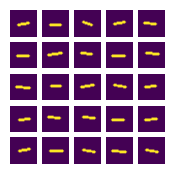

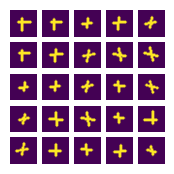

In [2]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [3]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #4768

X_text: "23+84" = y_text: "107"


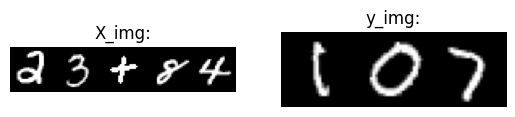

Query #1924

X_text: "9+62 " = y_text: "71 "


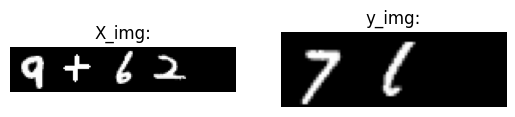

Query #4386

X_text: "21+93" = y_text: "114"


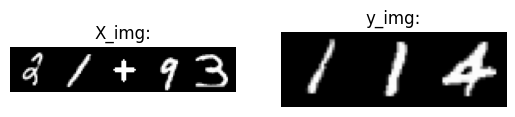

Query #1614

X_text: "8+7  " = y_text: "15 "


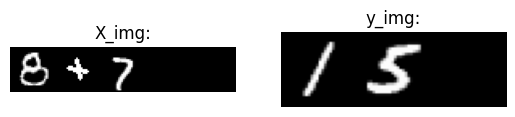

Query #9799

X_text: "48-99" = y_text: "-51"


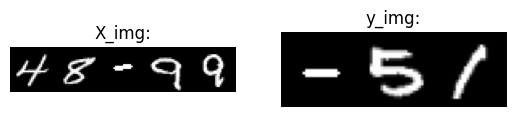

Query #197

X_text: "0-98 " = y_text: "-98"


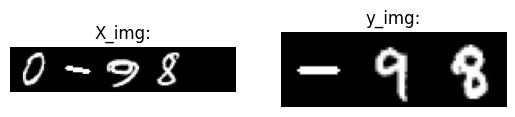

Query #8477

X_text: "42-38" = y_text: "4  "


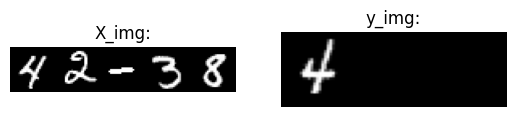

Query #9767

X_text: "48-83" = y_text: "-35"


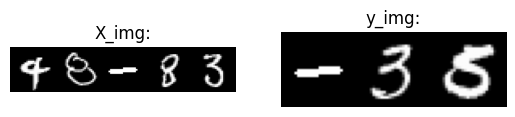

Query #4461

X_text: "22-30" = y_text: "-8 "


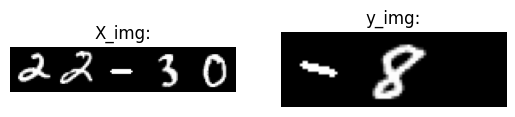

Query #4187

X_text: "20-93" = y_text: "-73"


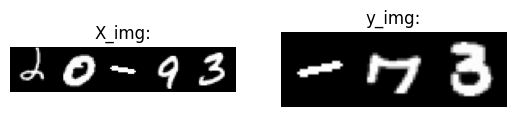

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

# Helper functions

The functions below will help with input/output of the data.

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=2)
    predicted = [''.join([unique_characters[i] for i in j]) for j in pred]

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

# I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [6]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [7]:
## Your code (look at the assignment description for your tasks for text-to-text model):
## Your first task is to fit the text2text model using X_text and y_text
text2text = build_text2text_model()

X_train_tt, X_test_tt, Y_train_tt, Y_test_tt = train_test_split(X_text_onehot, y_text_onehot, test_size=0.5, random_state=42)


history_tt = text2text.fit(
    X_train_tt, Y_train_tt,
    batch_size=32,
    epochs=20,
    validation_split=0.2
)

accuracy_tt = text2text.evaluate(X_test_tt, Y_test_tt)


print("Test accuracy:", accuracy_tt)

I0000 00:00:1764877183.431622  711266 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6230 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
/vol/home/s4786793/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-12-04 20:39:48.387111: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3582 - loss: 1.9441 - val_accuracy: 0.4053 - val_loss: 1.6762
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4368 - loss: 1.5793 - val_accuracy: 0.4772 - val_loss: 1.4823
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4945 - loss: 1.4035 - val_accuracy: 0.5253 - val_loss: 1.3259
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5280 - loss: 1.3035 - val_accuracy: 0.5603 - val_loss: 1.2402
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5540 - loss: 1.2213 - val_accuracy: 0.5798 - val_loss: 1.1568
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5803 - loss: 1.1502 - val_accuracy: 0.5715 - val_loss: 1.1462
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5953 - loss: 1.1049 - val_accuracy: 0.6008 - val_loss: 1.0710
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6053 - loss: 1.0666 - val_accuracy: 0.6125 - val_

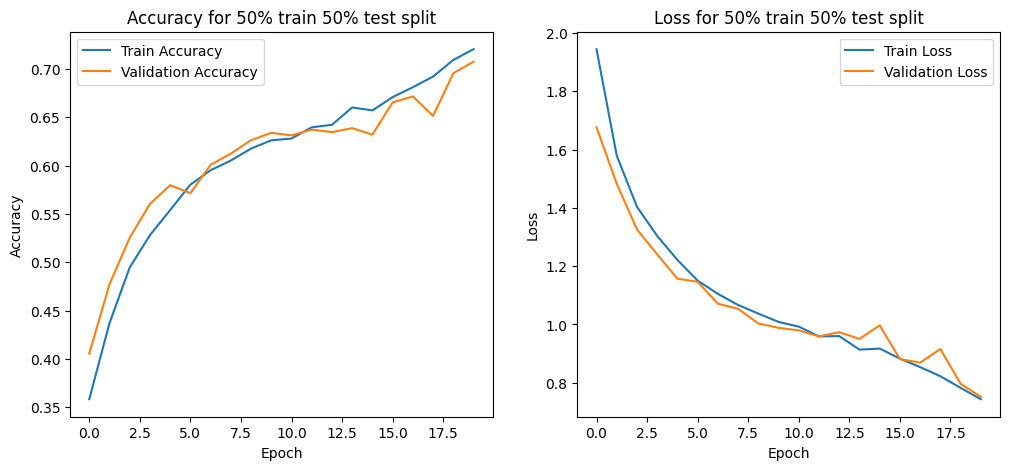

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_tt.history['accuracy'], label='Train Accuracy')
plt.plot(history_tt.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy for 50% train 50% test split')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_tt.history['loss'], label='Train Loss')
plt.plot(history_tt.history['val_loss'], label='Validation Loss')
plt.title('Loss for 50% train 50% test split')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [9]:
text2text = build_text2text_model()

X_train_tt, X_test_tt, Y_train_tt, Y_test_tt = train_test_split(X_text_onehot, y_text_onehot, test_size=0.75, random_state=42)


history_tt = text2text.fit(
    X_train_tt, Y_train_tt,
    batch_size=32,
    epochs=20,
    validation_split=0.2
)


accuracy_tt = text2text.evaluate(X_test_tt, Y_test_tt)

print("Test accuracy:", accuracy_tt)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3283 - loss: 2.0927 - val_accuracy: 0.4007 - val_loss: 1.8428
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3940 - loss: 1.7657 - val_accuracy: 0.4163 - val_loss: 1.6757
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4146 - loss: 1.6380 - val_accuracy: 0.4157 - val_loss: 1.6594
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4497 - loss: 1.5248 - val_accuracy: 0.4893 - val_loss: 1.4807
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4748 - loss: 1.4541 - val_accuracy: 0.4697 - val_loss: 1.4183
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5093 - loss: 1.3497 - val_accuracy: 0.5147 - val_loss: 1.3337
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5312 - loss: 1.3003 - val_accuracy: 0.5567 - val_loss: 1.2556
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5311 - loss: 1.2791 - val_accuracy: 0.

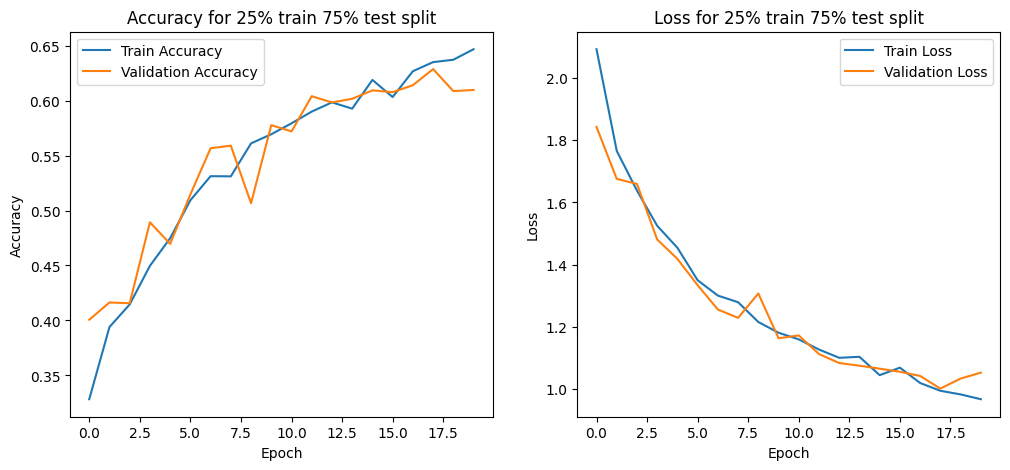

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_tt.history['accuracy'], label='Train Accuracy')
plt.plot(history_tt.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy for 25% train 75% test split')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_tt.history['loss'], label='Train Loss')
plt.plot(history_tt.history['val_loss'], label='Validation Loss')
plt.title('Loss for 25% train 75% test split')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [11]:
text2text = build_text2text_model()


X_train_tt, X_test_tt, Y_train_tt, Y_test_tt = train_test_split(X_text_onehot, y_text_onehot, test_size=0.9, random_state=42)


history_tt = text2text.fit(
    X_train_tt, Y_train_tt,
    batch_size=32,
    epochs=20,
    validation_split=0.2
)


accuracy_tt = text2text.evaluate(X_test_tt, Y_test_tt)

print("Test accuracy:", accuracy_tt)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2602 - loss: 2.2999 - val_accuracy: 0.3083 - val_loss: 2.1343
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3710 - loss: 1.9890 - val_accuracy: 0.3933 - val_loss: 1.8854
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3894 - loss: 1.8505 - val_accuracy: 0.4025 - val_loss: 1.8308
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3890 - loss: 1.7736 - val_accuracy: 0.4008 - val_loss: 1.7776
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3990 - loss: 1.7049 - val_accuracy: 0.3983 - val_loss: 1.7147
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4096 - loss: 1.6527 - val_accuracy: 0.4267 - val_loss: 1.6367
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4185 - loss: 1.5910 - val_accuracy: 0.4442 - val_loss: 1.6295
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4358 - loss: 1.5521 - val_accuracy: 0.4350 - val_loss

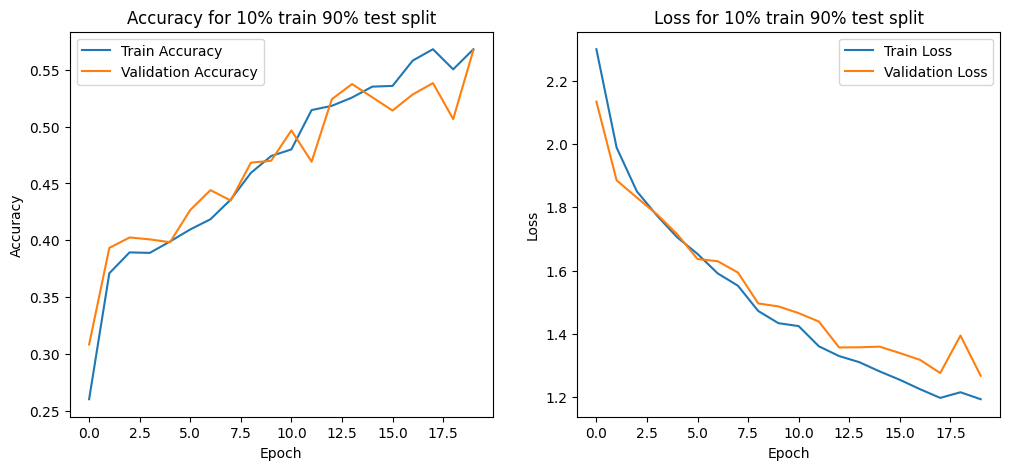

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_tt.history['accuracy'], label='Train Accuracy')
plt.plot(history_tt.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy for 10% train 90% test split')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_tt.history['loss'], label='Train Loss')
plt.plot(history_tt.history['val_loss'], label='Validation Loss')
plt.title('Loss for 10% train 90% test split')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


---
---

# I. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [43]:
def build_img2text_model_1():
    cnn = tf.keras.Sequential()

    cnn.add(Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
    cnn.add(MaxPooling2D((2,2)))
    cnn.add(Flatten())

    model = tf.keras.Sequential()
    model.add(TimeDistributed(cnn, input_shape=(5, 28, 28, 1)))
    model.add(LSTM(256))
    model.add(RepeatVector(max_answer_length))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [45]:
X_train_it, X_test_it, Y_train_it, Y_test_it = train_test_split(X_img, y_text_onehot, test_size=0.2, random_state=42)

In [46]:
img2text = build_img2text_model_1()
img2text.summary()

history_it = img2text.fit(
    X_train_it, Y_train_it,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop]
)
y_pred_it = img2text.evaluate(X_test_it, Y_test_it)

print("Test accuracy:", y_pred_it)

/vol/home/s4786793/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/vol/home/s4786793/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, 5, 5408)        │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 256)            │     5,800,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,329,933 (24.15 MB)

 Trainable params: 6,329,933 (24.15 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, 5, 5408)        │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 256)            │     5,800,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,329,933 (24.15 MB)

 Trainable params: 6,329,933 (24.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3713 - loss: 1.9012 - val_accuracy: 0.4111 - val_loss: 1.6772
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4419 - loss: 1.5645 - val_accuracy: 0.4611 - val_loss: 1.4921
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4889 - loss: 1.4071 - val_accuracy: 0.4921 - val_loss: 1.4012
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5254 - loss: 1.2969 - val_accuracy: 0.5130 - val_loss: 1.3514
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5558 - loss: 1.2105 - val_accuracy: 0.5202 - val_loss: 1.3248
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5855 - loss: 1.1235 - val_accuracy: 0.5273 - val_loss: 1.3384
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6147 - loss: 1.0458 - val_accuracy: 0.5205 - val_loss: 1.3786
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6448 - loss: 0.9732 - 

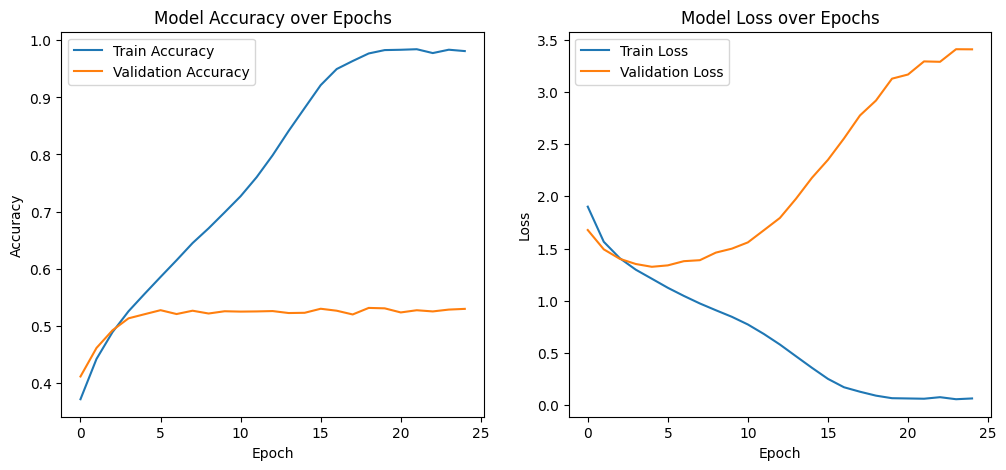

In [47]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_it.history['accuracy'], label='Train Accuracy')
plt.plot(history_it.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_it.history['loss'], label='Train Loss')
plt.plot(history_it.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

---
---

# III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [20]:
# helper funtion for plotting
def display_digits(y_pred, y_true, query_set):
    for i in range(len(y_pred)):
        plt.figure(figsize=(8,4))
        
        for t in range(3):
            # predicted
            plt.subplot(2, 3, t+1)
            plt.imshow(y_pred[i, t], cmap='gray')
            plt.title(f"Pred {t}")
            plt.axis('off')

            # true label
            plt.subplot(2, 3, t+1 + 3)
            plt.imshow(y_true[i, t], cmap='gray')
            plt.title(f"True {t}")
            plt.axis('off')

        plt.suptitle(f"Query: '{query_set[i]}'")
        plt.tight_layout()
        plt.show()

In [21]:
# train and test split
indices = np.arange(len(X_text_onehot))

train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

X_train_ti = X_text_onehot[train_idx]
X_test_ti  = X_text_onehot[test_idx]
y_train_ti = y_img[train_idx]
y_test_ti  = y_img[test_idx]
y_test_labels_ti = y_text[test_idx]
y_train_labels_ti = y_text[train_idx]

In [22]:
# Model with regular vector-based decoder
def build_text2img_model():
    text2img = tf.keras.Sequential([
        tf.keras.Input(shape=(None, len(unique_characters))),
        LSTM(256),
        RepeatVector(max_answer_length),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(28*28, activation='sigmoid')),
        TimeDistributed(Reshape((28, 28)))
    ])

    text2img.compile(loss='binary_crossentropy', optimizer='adam')
    text2img.summary()

    return text2img

In [23]:
text2img = build_text2img_model()
history_t2i = text2img.fit(X_train_ti, 
                           y_train_ti,
                           validation_split=0.2,
                           epochs=40)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 3, 784)         │       201,488 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 3, 28, 28)      │             0 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,003,280 (3.83 MB)

 Trainable params: 1,003,280 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2403 - val_loss: 0.2154
Epoch 2/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2153 - val_loss: 0.2157
Epoch 3/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2153 - val_loss: 0.2151
Epoch 4/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2128 - val_loss: 0.2069
Epoch 5/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1987 - val_loss: 0.1915
Epoch 6/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1903 - val_loss: 0.1889
Epoch 7/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1884 - val_loss: 0.1874
Epoch 8/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1868 - val_loss: 0.1884
Epoch 9/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1857 - val_loss: 0.1847
Epoch 10/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1849 - val_loss: 0.1846
Epoch 11/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1837 - val_loss: 0.1833
Epoch 12/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


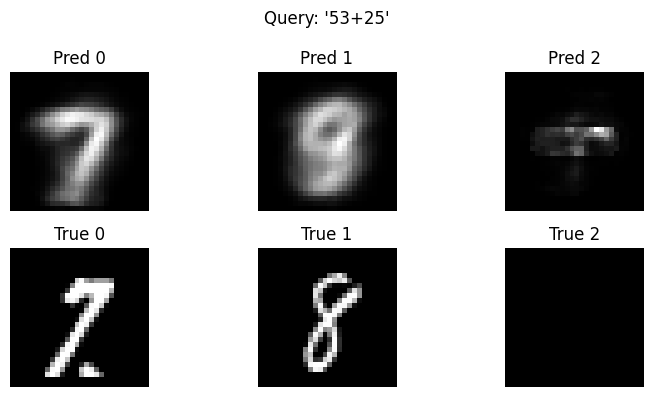

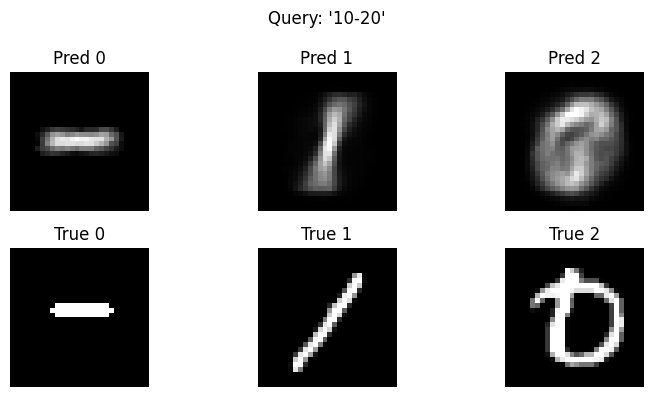

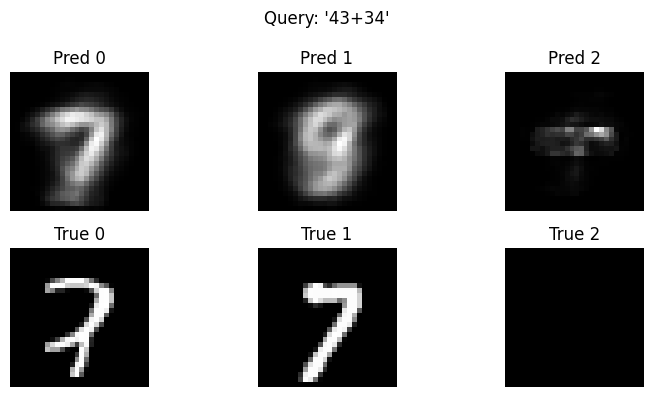

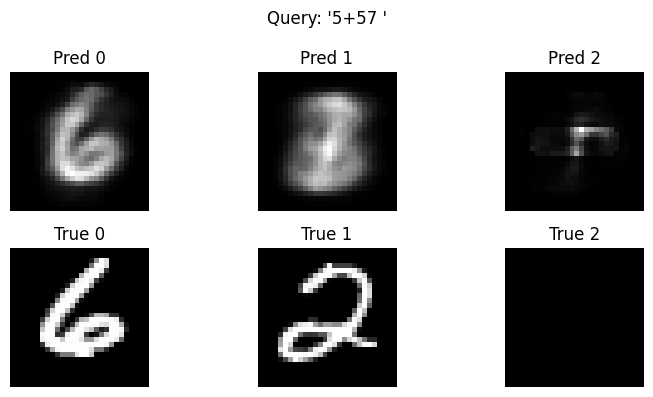

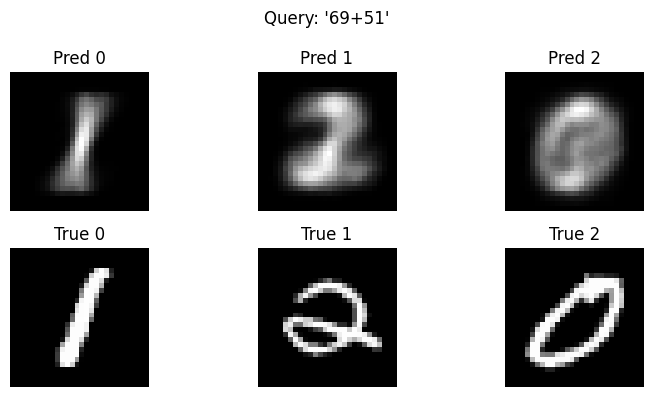

In [24]:
# Predict first 5 test images
y_pred_img_reg = text2img.predict(X_test_ti[:5])
y_true_reg = y_test_ti[:5]
query_set_reg = X_text[test_idx[:5]]

display_digits(y_pred_img_reg, y_true_reg, query_set_reg)

In [ ]:
def build_text2img_model_conv(): 
    text2img_conv = tf.keras.Sequential([
        # encoder
        LSTM(512,input_shape=(None, len(unique_characters))),
        # encoded vector 
        RepeatVector(max_answer_length),
                     
        # decoder 
        LSTM(512, return_sequences=True),
        
        BatchNormalization(), 
                                    
        # transposed convolutions
        # feature expansion 
        TimeDistributed(Dense(7*7*128, use_bias=True)), 
        TimeDistributed(BatchNormalization()),
        Activation(tf.keras.activations.leaky_relu),

        TimeDistributed(Reshape((7, 7, 128))),  
        
        # upsampling 1 -> 7x7 to 14x14
        TimeDistributed(Conv2DTranspose(128, (3,3), strides=2, padding='same', use_bias=True)), 
        TimeDistributed(BatchNormalization()), 
        Activation(tf.keras.activations.leaky_relu),
                                
        # convolution layer   
        TimeDistributed(Conv2D(64, (3,3), strides=1, padding='same')), 
        Activation(tf.keras.activations.leaky_relu),
        
        
        # upsampling 2 -> 14x14 to 28x28
        TimeDistributed(Conv2DTranspose(32, (3,3), strides=2, padding='same')), 
        TimeDistributed(BatchNormalization()), 
        Activation(tf.keras.activations.leaky_relu),
         
        # convolution layer -- output layer
        TimeDistributed(Conv2D(1, (3,3), strides=1, padding='same', activation='sigmoid'))]) 

    text2img_conv.compile(loss='binary_crossentropy', optimizer='adam') 
    text2img_conv.summary() 
    return text2img_conv 

In [26]:
text2img_conv = build_text2img_model_conv() 
history_t2i_conv = text2img_conv.fit(X_train_ti, 
                                y_train_ti, 
                                validation_split = 0.2, 
                                epochs = 40)

/vol/home/s4786793/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 512)            │     1,077,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 3, 6272)        │     3,217,536 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 3, 6272)        │        25,088 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 3, 6272)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 3, 7, 7, 128)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 3, 14, 14, 128) │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 3, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 3, 14, 14, 64)  │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 14, 14, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 3, 28, 28, 32)  │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 3, 28, 28, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3, 28, 28, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 3, 28, 28, 1)   │           289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,661,889 (25.41 MB)

 Trainable params: 6,648,001 (25.36 MB)

 Non-trainable params: 13,888 (54.25 KB)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 0.2146 - val_loss: 0.2062
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1925 - val_loss: 0.1954
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1900 - val_loss: 0.1960
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1874 - val_loss: 0.1956
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1861 - val_loss: 0.1887
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.1847 - val_loss: 0.1867
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1836 - val_loss: 0.1863
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1828 - val_loss: 0.1881
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1819 - val_loss: 0.1868
Epoch 10/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1810 - val_loss: 0.1831
Epoch 11/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1800 - val_loss: 0.1835
Epoch 12/50
400/400 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


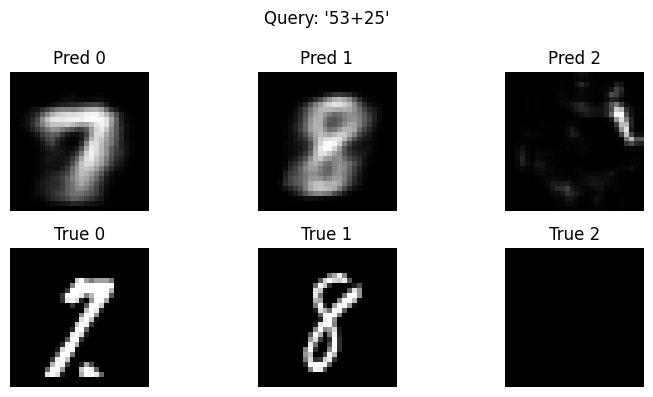

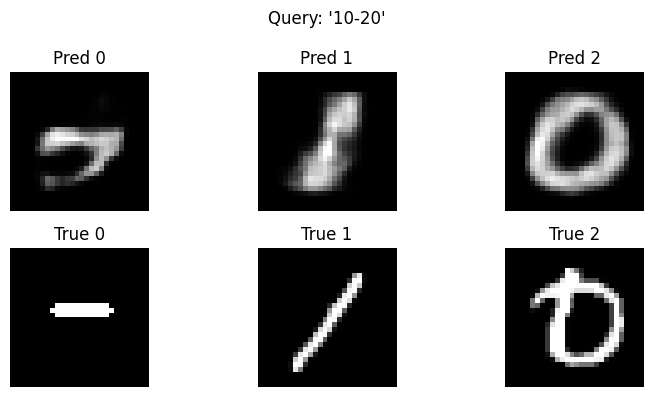

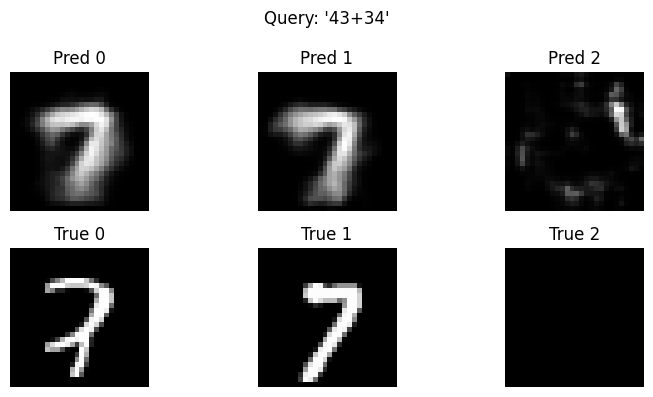

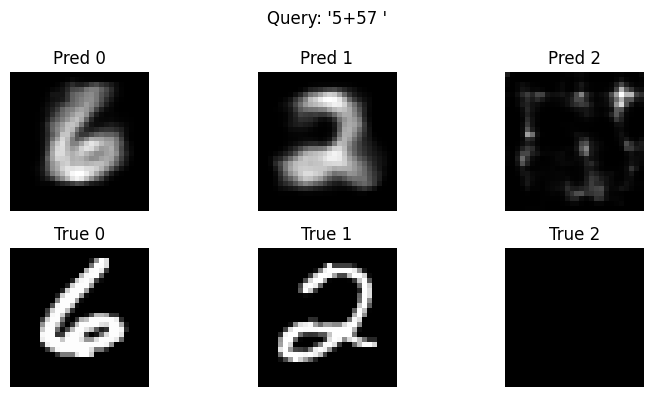

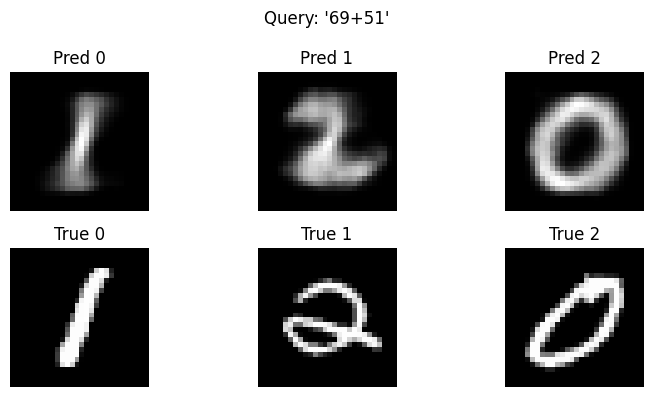

In [27]:
y_pred_img_conv = text2img_conv.predict(X_test_ti[:5])
y_true_conv = y_test_ti[:5]
query_set_conv = X_text[test_idx[:5]]

display_digits(y_pred_img_conv, y_true_conv, query_set_conv)

In [28]:
# cnn classifier for evaluating generated digits
def build_digit_cnn_classifier():
    cnn = tf.keras.Sequential([
        tf.keras.layers.Input(shape=[28, 28, 1]),
        tf.keras.layers.Conv2D(64, 7, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        
        tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        # "0123456789- "
        tf.keras.layers.Dense(12, activation="softmax")
    ])
    cnn.compile(loss="sparse_categorical_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])
    
    return cnn

In [ ]:
# separating the text digits --> label of cnn
label_map = {str(d): d for d in range(10)}
label_map['-'] = 10
label_map[' '] = 11

separated_labels_train = []
for s in y_text:
    for char in s:
        separated_labels_train.append(label_map[char])
separated_labels_train = np.array(separated_labels_train)

# separating the image digits --> features of cnn
y_img_separated = y_img.reshape(-1,28,28,1)

# separating the image digits --> to be used with prediction
separated_labels_test = []
for s in y_test_labels_ti:
    for char in s:
        separated_labels_test.append(label_map[char])
separated_labels_test = np.array(separated_labels_test)

X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN, = train_test_split(y_img_separated, separated_labels_train, test_size=0.2)

In [30]:
# build and train cnn
cnn_model = build_digit_cnn_classifier()

history = cnn_model.fit(X_train_CNN, 
                        y_train_CNN, 
                        epochs=20,
                        validation_split=0.2)

Epoch 1/20


2025-12-04 13:38:34.165327: I external/local_xla/xla/service/service.cc:163] XLA service 0x70954620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-04 13:38:34.165349: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-12-04 13:38:34.217070: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-04 13:38:34.762345: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-04 13:38:34.762510: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them s

  59/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2462 - loss: 2.3134

I0000 00:00:1764851921.546820  506351 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1196/1200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7252 - loss: 0.8611

2025-12-04 13:38:44.896627: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-04 13:38:46.087151: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 100 bytes spill stores, 100 bytes spill loads



1200/1200 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8662 - loss: 0.4353 - val_accuracy: 0.9824 - val_loss: 0.0674
Epoch 2/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9660 - loss: 0.1269 - val_accuracy: 0.9854 - val_loss: 0.0729
Epoch 3/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9763 - loss: 0.0884 - val_accuracy: 0.9923 - val_loss: 0.0355
Epoch 4/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9815 - loss: 0.0701 - val_accuracy: 0.9885 - val_loss: 0.0476
Epoch 5/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9853 - loss: 0.0584 - val_accuracy: 0.9934 - val_loss: 0.0299
Epoch 6/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9878 - loss: 0.0440 - val_accuracy: 0.9910 - val_loss: 0.0501
Epoch 7/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9878 - loss: 0.0461 - val_accuracy: 0.9921 - val_loss: 0.0418
Epoch 8/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9889 - loss: 0.0409 - val_accura

In [31]:
# prediction == generation
y_pred_img_reg = text2img.predict(X_test_ti)

# separating predicted digits
generated_images_reg = y_pred_img_reg.reshape(-1, 28, 28, 1)

# cnn prediction
digit_preds_reg = cnn_model.predict(generated_images_reg)
digit_preds_reg = np.argmax(digit_preds_reg, axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [32]:
# prediction == generation
y_pred_img_conv = text2img_conv.predict(X_test_ti)

# separating predicted digits
generated_images_conv = y_pred_img_conv.reshape(-1, 28, 28, 1)
# cnn prediction
digit_preds_conv = cnn_model.predict(generated_images_conv)
digit_preds_conv = np.argmax(digit_preds_conv, axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [21]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:

report_reg = classification_report(separated_labels_test, digit_preds_reg)
report_conv = classification_report(separated_labels_test, digit_preds_conv)
print("Classification Report for Dense Decoder:")
print(report_reg)
print("Classification Report for ConvTranspose Decoder:")
print(report_conv)

Classification Report for Dense Decoder:
              precision    recall  f1-score   support

           0       0.99      0.17      0.29       597
           1       1.00      0.08      0.14      1991
           2       0.00      0.00      0.00       926
           3       0.00      0.00      0.00       827
           4       0.00      0.00      0.00       860
           5       0.00      0.00      0.00       718
           6       0.00      0.00      0.00       750
           7       0.00      0.00      0.00       707
           8       0.00      0.00      0.00       618
           9       0.00      0.00      0.00       596
          10       1.00      0.97      0.98      1014
          11       0.22      1.00      0.36      2396

    accuracy                           0.30     12000
   macro avg       0.27      0.18      0.15     12000
weighted avg       0.34      0.30      0.19     12000

Classification Report for ConvTranspose Decoder:
              precision    recall  f1-score

/vol/home/s4786793/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/vol/home/s4786793/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/vol/home/s4786793/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

In [34]:
import seaborn as sns
# Compute confusion matrices
cm_reg  = confusion_matrix(separated_labels_test, digit_preds_reg)
cm_conv = confusion_matrix(separated_labels_test, digit_preds_conv)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

labels = [str(i) for i in range(10)] + ['-', ' ']

# --- Model 1: Dense decoder ---
sns.heatmap(cm_reg, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Confusion Matrix — Dense Decoder (Vector-based)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# --- Model 2: ConvTranspose decoder ---
sns.heatmap(cm_conv, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title("Confusion Matrix — ConvTranspose Decoder")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

NameError: name 'separated_labels_test' is not defined

---
---

# IV. Additional LSTM layers

Try adding additional LSTM layers to your encoder networks and see how the performance of your
 models changes. Try to explain these performance differences in the context of the mistakes that
 your network was making before. Tip: you should add a flag ”return sequences=True” to the first
 recurrent layer of your network.

In [13]:
# helper function - display confusion matrix heatmap
def display_comparison_heapmaps(cm1, cm2, cm1_title, cm2_title):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    labels = [str(i) for i in range(10)] + ['-', ' ']

    # --- Model 1: Dense decoder ---
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title(cm1_title)
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # --- Model 2: ConvTranspose decoder ---
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Purples',
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title(cm2_title)
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()

In [ ]:
# separating the text digits --> label of cnn
label_map['-'] = 10
label_map = {str(d): d for d in range(10)}
label_map[' '] = 11

def separate_labels(labels_set, label_map = label_map):
    separated_labels = []
    for s in labels_set:
        for char in s:
            separated_labels.append(label_map[char])
    separated_labels = np.array(separated_labels)

    return separated_labels

## I. Text to Text Model Extended

In [14]:
def build_text2text_model_extended():
    text2text = tf.keras.Sequential()

    text2text.add(LSTM(256, input_shape=(None, len(unique_characters)), return_sequences=True))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(LSTM(256))

    text2text.add(RepeatVector(max_answer_length))

    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(LSTM(256, return_sequences=True))
    text2text.add(LSTM(256, return_sequences=True))

    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [15]:
text2text_extended = build_text2text_model_extended()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, None, 256)      │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, None, 256)      │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, None, 256)      │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,957,005 (15.09 MB)

 Trainable params: 3,957,005 (15.09 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
X_train_tt, X_test_tt, Y_train_tt, Y_test_tt = train_test_split(X_text_onehot, y_text_onehot, test_size=0.5, random_state=42)

In [41]:
history_t2t_extended = text2text_extended.fit(X_train_tt, 
                                Y_train_tt, 
                                validation_split = 0.2, 
                                epochs = 20)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7036 - loss: 0.7651 - val_accuracy: 0.7125 - val_loss: 0.7252
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7106 - loss: 0.7458 - val_accuracy: 0.7107 - val_loss: 0.7336
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7140 - loss: 0.7553 - val_accuracy: 0.7077 - val_loss: 0.7329
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7142 - loss: 0.7314 - val_accuracy: 0.7068 - val_loss: 0.7519
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7194 - loss: 0.7242 - val_accuracy: 0.7157 - val_loss: 0.7324
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7150 - loss: 0.7352 - val_accuracy: 0.7148 - val_loss: 0.7332
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7113 - loss: 0.7437 - val_accuracy: 0.7103 - val_loss: 0.7335
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7151 - loss: 0.7295 - val_accu

In [ ]:
y_pred_tt_extended = decode_labels(text2text_extended.predict(X_test_tt))
separated_pred_tt_extended = separate_labels(y_pred_tt_extended)

y_pred_tt = decode_labels(text2text.predict(X_test_tt))
separated_pred_tt = separate_labels(y_pred_tt)

Y_test_tt = decode_labels(Y_test_tt)
separated_test_tt = separate_labels(Y_test_tt)


title_t2t = "Baseline Text to Text Model"
title_t2t_extended =  "Extended Text to Text Model"

report_t2t = classification_report(separated_test_tt, separated_pred_tt)
print("Classification Report for",title_t2t)
print(report_t2t)
report_t2t_extended = classification_report(separated_test_tt, separated_pred_tt_extended)
print("Classification Report for",title_t2t_extended)
print(report_t2t_extended)

  1/313 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report for Text to Text Model
              precision    recall  f1-score   support

           0       0.39      0.31      0.35      1490
           1       0.74      0.70      0.72      4887
           2       0.53      0.37      0.43      2280
           3       0.37      0.40      0.38      2160
           4       0.60      0.20      0.31      2095
           5       0.50      0.23      0.31      1948
           6       0.23      0.40      0.29      1823
           7       0.22      0.35      0.27      1736
           8       0.31      0.12      0.17      1638
           9       0.23      0.35      0.27      1498
          10       0.94      0.99      0.96      2486
          11       0.83      1.00      0.90      5959

    accuracy                           0.56     30000
   macro avg       0.49      0.45      0.45     30000
weighted avg       0.58      0.56      0.55     30000

Classi

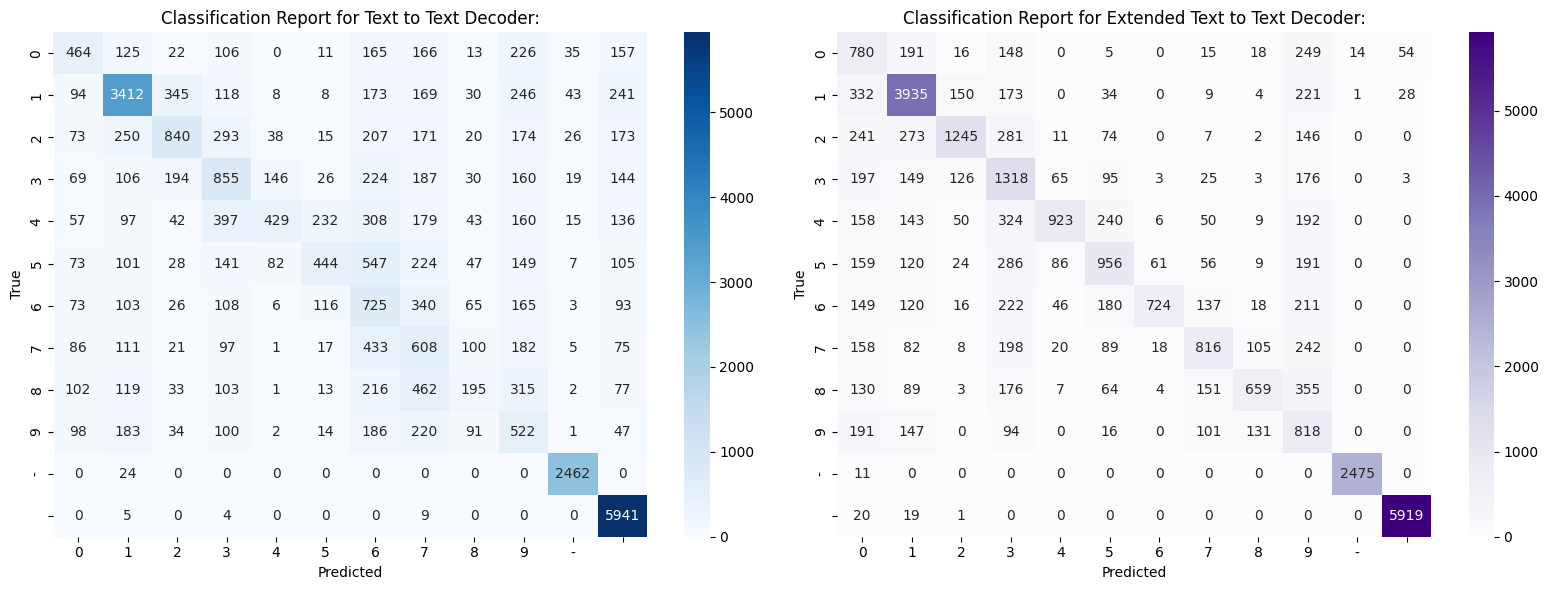

In [38]:
cm_t2t = confusion_matrix(separated_test_tt, separated_pred_tt)
cm_t2t_extended = confusion_matrix(separated_test_tt, separated_pred_tt_extended)
display_comparison_heapmaps(cm_t2t, cm_t2t_extended, title_t2t, title_t2t_extended)

## II. Image to Text Model Extended

In [63]:
def build_img2text_model_1_extended():
    cnn = tf.keras.Sequential()

    cnn.add(Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
    cnn.add(MaxPooling2D((2,2)))
    cnn.add(Flatten())

    model = tf.keras.Sequential()
    model.add(TimeDistributed(cnn, input_shape=(5, 28, 28, 1)))

    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256))
    model.add(RepeatVector(max_answer_length))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))

    model.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [64]:
img2text_extended = build_img2text_model_1_extended()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_12             │ (None, 5, 5408)        │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 5, 256)         │     5,800,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 5, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_8 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,431,181 (32.16 MB)

 Trainable params: 8,431,181 (32.16 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
X_train_it, X_test_it, Y_train_it, Y_test_it = train_test_split(X_img, y_text_onehot, test_size=0.2, random_state=42)

In [67]:
history_i2t_extended = img2text_extended.fit(
    X_train_it, Y_train_it,
    batch_size=32,
    epochs=40,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.3116 - loss: 2.0901 - val_accuracy: 0.3280 - val_loss: 2.0474
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3239 - loss: 2.0036 - val_accuracy: 0.3259 - val_loss: 1.8736
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3720 - loss: 1.7466 - val_accuracy: 0.4243 - val_loss: 1.5988
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4549 - loss: 1.5003 - val_accuracy: 0.4684 - val_loss: 1.4739
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4981 - loss: 1.3655 - val_accuracy: 0.4983 - val_loss: 1.3757
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5366 - loss: 1.2550 - val_accuracy: 0.5122 - val_loss: 1.3666
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5621 - loss: 1.1722 - val_accuracy: 0.5346 - val_loss: 1.3068
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5854 - loss: 1.1101 -

In [68]:
y_pred_it_extended = decode_labels(img2text_extended.predict(X_test_it))
separated_pred_it_extended = separate_labels(y_pred_it_extended)

y_pred_it = decode_labels(img2text.predict(X_test_it))
separated_pred_it = separate_labels(y_pred_it)

Y_test_it = decode_labels(Y_test_it)
separated_test_it = separate_labels(Y_test_it)


title_i2t = "Baseline Image to Text Model"
title_i2t_extended =  "Extended Image to Text Model"

report_i2t = classification_report(separated_test_it, separated_pred_it)
print("Classification Report for",title_i2t)
print(report_i2t)
report_i2t_extended = classification_report(separated_test_it, separated_pred_it_extended)
print("Classification Report for",title_i2t_extended)
print(report_i2t_extended)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report for Baseline Image to Text Model
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       597
           1       0.30      0.61      0.41      1991
           2       0.13      0.55      0.21       926
           3       0.00      0.00      0.00       827
           4       0.00      0.00      0.00       860
           5       0.00      0.00      0.00       718
           6       0.00      0.00      0.00       750
           7       0.00      0.00      0.00       707
           8       0.00      0.00      0.00       618
           9       0.00      0.00      0.00       596
          10       0.00      0.00      0.00      1014
          11       0.55      0.92      0.69      2396

    accuracy                           0.33     12000
   macro avg       0.08      0.17      0.11     12000
weighted avg       0.17      0.33      0.22     120

/vol/home/s4786793/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/vol/home/s4786793/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/vol/home/s4786793/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

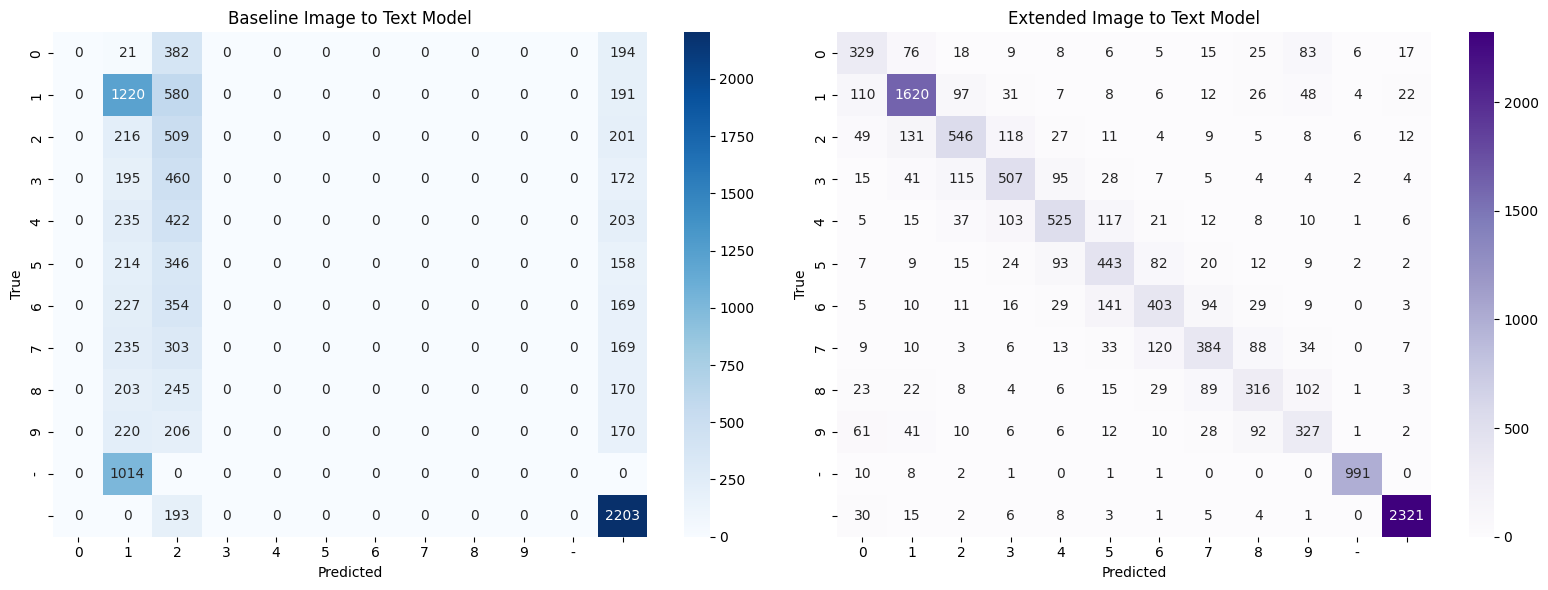

In [69]:
cm_i2t = confusion_matrix(separated_test_it, separated_pred_it)
cm_i2t_extended = confusion_matrix(separated_test_it, separated_pred_it_extended)
display_comparison_heapmaps(cm_i2t, cm_i2t_extended, title_i2t, title_i2t_extended)

## III.Text to Image Model Extended

In [27]:
def build_text2img_model_conv_extended(): 
    text2img_conv = tf.keras.Sequential([
        # encoder
        # in - (batch, 5, 13)
        # out - (batch, 5, 512)
        LSTM(512,input_shape=(None, len(unique_characters)), return_sequences=True),
        # in - (batch, 5, 512)
        # out - (batch, 512)
        LSTM(512, return_sequences=True),
        LSTM(512, return_sequences=True),
        LSTM(512),
        
        # encoded vector 
        RepeatVector(max_answer_length),
                     
        # decoder 
        LSTM(512, return_sequences=True),
        LSTM(512, return_sequences=True),
        LSTM(512, return_sequences=True),
        LSTM(512, return_sequences=True),
        
        BatchNormalization(), 
                                        
        # transposed convolutions
        # feature expansion 
        TimeDistributed(Dense(7*7*128, use_bias=True)), 
        TimeDistributed(BatchNormalization()),
        Activation(tf.keras.activations.leaky_relu),

        TimeDistributed(Reshape((7, 7, 128))),  
        
        # upsampling 1 -> 7x7 to 14x14
        TimeDistributed(Conv2DTranspose(128, (3,3), strides=2, padding='same', use_bias=True)), 
        TimeDistributed(BatchNormalization()), 
        Activation(tf.keras.activations.leaky_relu),
                                
        
        # convolution layer   
        TimeDistributed(Conv2D(64, (3,3), strides=1, padding='same')), 
        Activation(tf.keras.activations.leaky_relu),
        
        
        # upsampling 2 -> 14x14 to 28x28
        TimeDistributed(Conv2DTranspose(32, (3,3), strides=2, padding='same')), 
        TimeDistributed(BatchNormalization()), 
        Activation(tf.keras.activations.leaky_relu),
        
        
        # convolution layer -- output layer
        TimeDistributed(Conv2D(1, (3,3), strides=1, padding='same', activation='sigmoid'))]) 

    text2img_conv.compile(loss='binary_crossentropy', optimizer='adam') 
    text2img_conv.summary() 
    return text2img_conv 

In [28]:
text2img_conv_extended = build_text2img_model_conv_extended()

/vol/home/s4786793/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, None, 512)      │     1,077,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, None, 512)      │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, None, 512)      │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 3, 6272)        │     3,217,536 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 3, 6272)        │        25,088 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 3, 6272)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 3, 7, 7, 128)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 3, 14, 14, 128) │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 3, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 3, 14, 14, 64)  │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 3, 14, 14, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 3, 28, 28, 32)  │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 3, 28, 28, 32)  │           12

 Total params: 19,257,089 (73.46 MB)

 Trainable params: 19,243,201 (73.41 MB)

 Non-trainable params: 13,888 (54.25 KB)

In [ ]:
history_t2i_conv_extended = text2img_conv_extended.fit(X_train_ti, 
                                y_train_ti, 
                                validation_split = 0.2, 
                                epochs = 50)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 512)            │     1,077,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 3, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 3, 6272)        │     3,217,536 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 3, 6272)        │        25,088 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 3, 6272)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 3, 7, 7, 128)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 3, 14, 14, 128) │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 3, 14, 14, 128) │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 3, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 3, 14, 14, 64)  │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 3, 14, 14, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 3, 28, 28, 32)  │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 3, 28, 28, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 3, 28, 28, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 3, 28, 28, 1)   │           289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,661,889 (25.41 MB)

 Trainable params: 6,648,001 (25.36 MB)

 Non-trainable params: 13,888 (54.25 KB)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.2226 - val_loss: 0.2122
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1918 - val_loss: 0.1971
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1888 - val_loss: 0.1929
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1866 - val_loss: 0.1942
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1850 - val_loss: 0.1894
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1840 - val_loss: 0.1866
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1831 - val_loss: 0.1863
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1819 - val_loss: 0.1843
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1810 - val_loss: 0.1829
Epoch 10/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1800 - val_loss: 0.1845
Epoch 11/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1795 - val_loss: 0.1819
Epoch 12/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


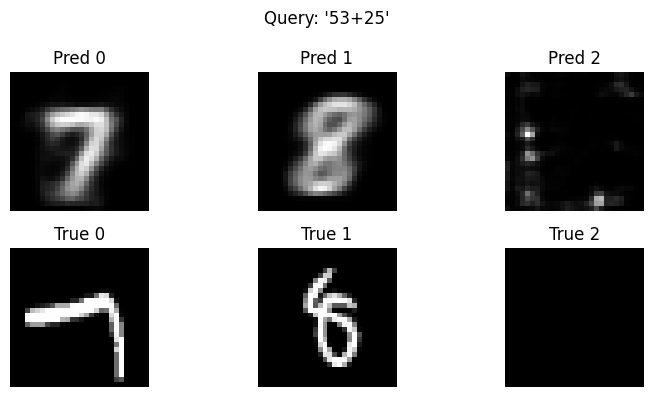

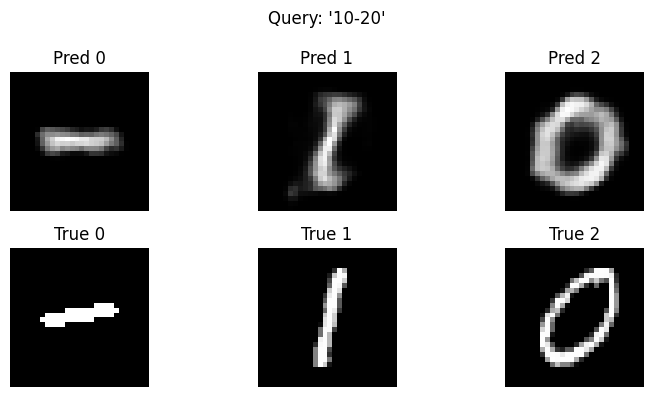

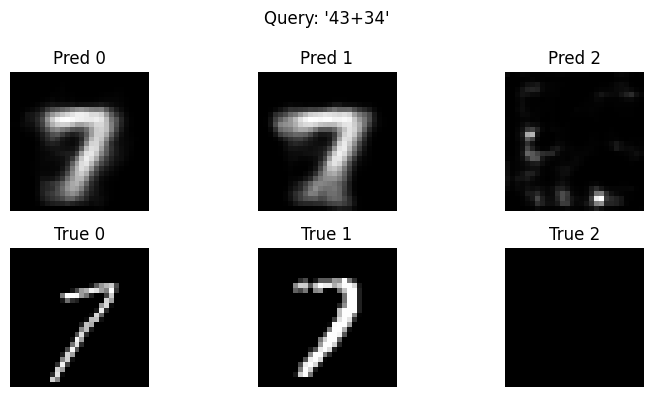

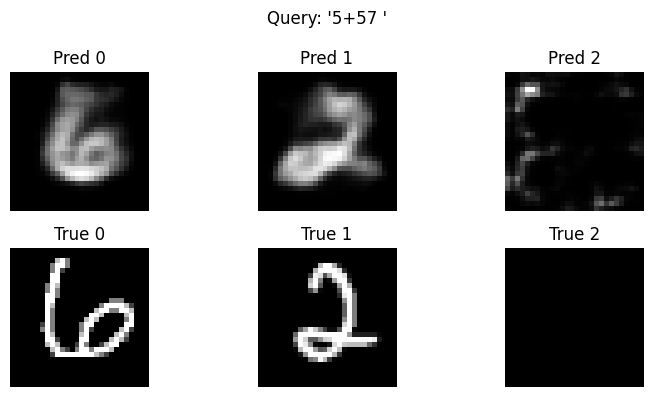

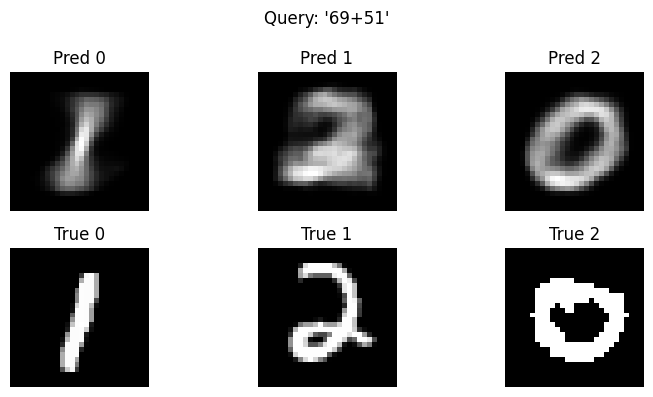

In [30]:
y_pred_img_conv_extended = text2img_conv_extended.predict(X_test_ti[:5])
y_true_conv_extended = y_test_ti[:5]
query_set_conv_extended = X_text[test_idx[:5]]

display_digits(y_pred_img_conv_extended, y_true_conv_extended, query_set_conv_extended)

In [31]:
# prediction == generation
y_pred_img_conv_extended = text2img_conv_extended.predict(X_test_ti)

# separating predicted digits
generated_images_conv_extended = y_pred_img_conv_extended.reshape(-1, 28, 28, 1)

# cnn prediction
digit_preds_conv_extended = cnn_model.predict(generated_images_conv_extended)
digit_preds_conv_extended = np.argmax(digit_preds_conv_extended, axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step


In [32]:
report_conv_extended = classification_report(separated_labels_test, digit_preds_conv_extended)
print("Classification Report for Extended ConvTranspose Decoder:")
print(report_conv_extended)

Classification Report for Extended ConvTranspose Decoder:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       597
           1       0.99      0.94      0.96      1991
           2       0.87      0.33      0.48       926
           3       0.98      0.59      0.73       827
           4       0.96      0.15      0.26       860
           5       0.94      0.14      0.25       718
           6       0.98      0.42      0.59       750
           7       0.85      0.43      0.57       707
           8       0.92      0.18      0.30       618
           9       0.83      0.79      0.81       596
          10       1.00      1.00      1.00      1014
          11       0.40      1.00      0.57      2396

    accuracy                           0.67     12000
   macro avg       0.89      0.57      0.62     12000
weighted avg       0.83      0.67      0.65     12000



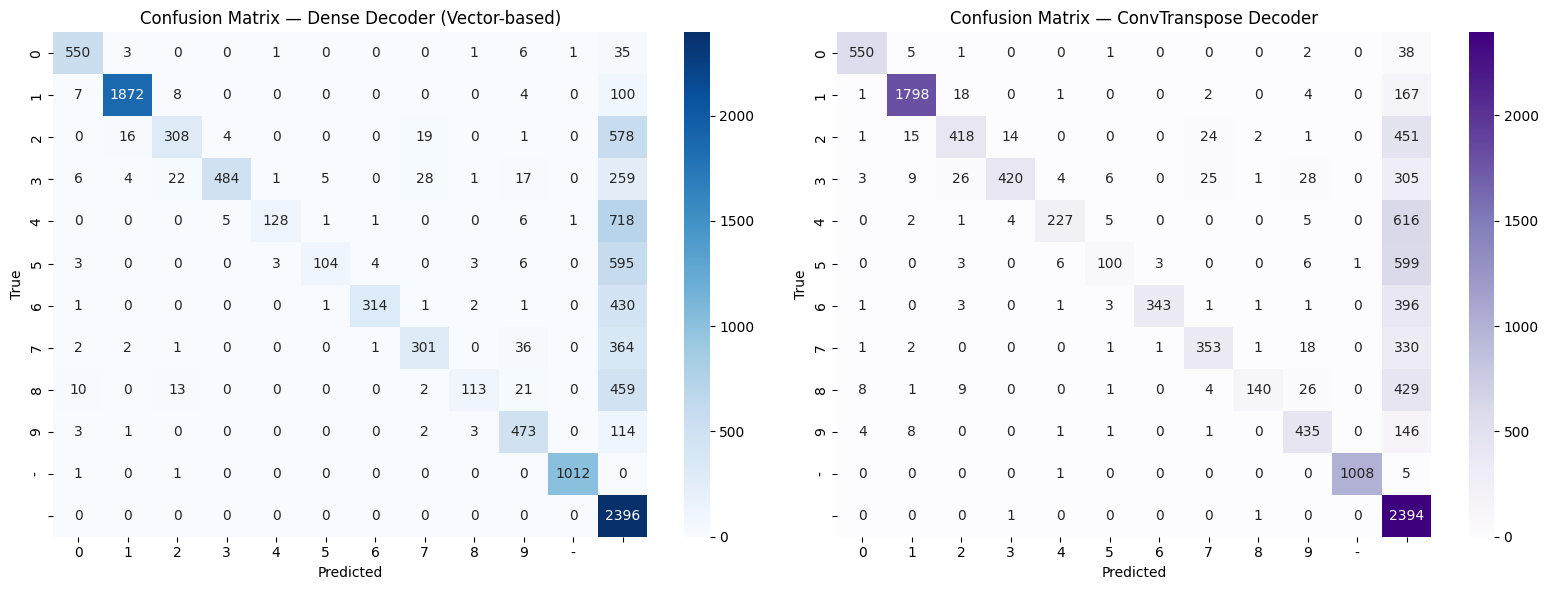

In [33]:
import seaborn as sns
# Compute confusion matrices
cm_conv_extended = confusion_matrix(separated_labels_test, digit_preds_conv_extended)
cm_conv = confusion_matrix(separated_labels_test, digit_preds_conv)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

labels = [str(i) for i in range(10)] + ['-', ' ']

# --- Model 1: Dense decoder ---
sns.heatmap(cm_conv_extended, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Confusion Matrix — Dense Decoder (Vector-based)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# --- Model 2: ConvTranspose decoder ---
sns.heatmap(cm_conv, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title("Confusion Matrix — ConvTranspose Decoder")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()